In [1]:
import pandas as pd
import os
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


In [2]:
import itertools

regions = ['1', '2', '3', '4', '5', '6']
combinations = []

for r in range(1, len(regions) + 1):
    combinations.extend(['_'.join(i) for i in itertools.combinations(regions, r)])

print(combinations)


['1', '2', '3', '4', '5', '6', '1_2', '1_3', '1_4', '1_5', '1_6', '2_3', '2_4', '2_5', '2_6', '3_4', '3_5', '3_6', '4_5', '4_6', '5_6', '1_2_3', '1_2_4', '1_2_5', '1_2_6', '1_3_4', '1_3_5', '1_3_6', '1_4_5', '1_4_6', '1_5_6', '2_3_4', '2_3_5', '2_3_6', '2_4_5', '2_4_6', '2_5_6', '3_4_5', '3_4_6', '3_5_6', '4_5_6', '1_2_3_4', '1_2_3_5', '1_2_3_6', '1_2_4_5', '1_2_4_6', '1_2_5_6', '1_3_4_5', '1_3_4_6', '1_3_5_6', '1_4_5_6', '2_3_4_5', '2_3_4_6', '2_3_5_6', '2_4_5_6', '3_4_5_6', '1_2_3_4_5', '1_2_3_4_6', '1_2_3_5_6', '1_2_4_5_6', '1_3_4_5_6', '2_3_4_5_6', '1_2_3_4_5_6']


In [4]:
import pandas as pd
import os
from scipy.stats import pearsonr
import itertools
import numpy as np
# Define the base directory
base_dir = "res_RL150/"

# Define the full combination
full_combination = "1_2_3_4_5_6"

# Generate all combinations
regions = ['1', '2', '3', '4', '5', '6']
combinations = []

for r in range(1, len(regions) + 1):
    combinations.extend(['_'.join(i) for i in itertools.combinations(regions, r)])

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['sample_number', 'region_combination', 'mutual_taxonomy', 'pearson_corr', 'num_regions'])

# Loop over samples
for sample_num in range(1, 25):  # assuming there are 24 samples

    # Define the full combination file name
    full_comb_file_name = "Reich_Qiagen_read_len_150_REGIONS_{0}_HardDecision_Freq_ResultsSummary_SPECIES_cutFreq0.txt".format(full_combination)

    # Define the full path to the file
    full_comb_file_path = os.path.join(base_dir, full_comb_file_name)

    # Load the full combination data
    full_comb_data = pd.read_csv(full_comb_file_path, sep="\t", skiprows=1)
    full_comb_data['Taxonomy'] = full_comb_data[['domain','phylum','class','order','family','genus','species']].apply(lambda x: '_'.join(x), axis=1)

    for comb in combinations:

        full_sample_column = 'qiagen_read_len_150_REGIONS_{0}/{1}'.format(full_combination, sample_num)
        Full_comp = full_comb_data[[full_sample_column, 'Taxonomy']]
        Full_comp = Full_comp[Full_comp[full_sample_column] > 0]  # Removing 0

        partial_comb_file_name = "Reich_Qiagen_read_len_150_REGIONS_{0}_HardDecision_Freq_ResultsSummary_SPECIES_cutFreq0.txt".format(comb)
        partial_comb_file_path = os.path.join(base_dir, partial_comb_file_name)
        partial_comb_data = pd.read_csv(partial_comb_file_path, sep="\t", skiprows=1)
        partial_comb_data['Taxonomy'] = partial_comb_data[['domain','phylum','class','order','family','genus','species']].apply(lambda x: '_'.join(x), axis=1)

        partial_sample_column = 'qiagen_read_len_150_REGIONS_{0}/{1}'.format(comb, sample_num)
        relavent_data = partial_comb_data[[partial_sample_column, 'Taxonomy']]
        relavent_data = relavent_data[relavent_data[partial_sample_column] > 0]  # Removing 0

        merged_data = pd.merge(Full_comp, relavent_data, on='Taxonomy', how='inner')

        # Calculations
        mutual_taxonomy = len(merged_data) / len(Full_comp)

        if comb == full_combination:
            pearson_corr = 1.0
        else:
            pearson_corr = pearsonr(merged_data[full_sample_column], merged_data[partial_sample_column])[0] if len(merged_data) > 1 else np.nan


        num_regions = len(comb.split('_'))

        # Append results to the DataFrame
        new_row = pd.DataFrame({
            'sample_number': [sample_num],
            'region_combination': [comb],
            'mutual_taxonomy': [mutual_taxonomy],
            'pearson_corr': [pearson_corr],
            'num_regions': [num_regions]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        results_df['num_regions'] = results_df['num_regions'].astype(int)

In [5]:
results_df

,sample_number,region_combination,mutual_taxonomy,pearson_corr,num_regions
0,1,1,0.277778,0.990483,1
1,1,2,0.355556,0.902456,1
2,1,3,0.333333,0.923687,1
3,1,4,0.359259,0.963318,1
4,1,5,0.292593,0.967780,1
...,...,...,...,...,...
1507,24,1_2_3_5_6,0.843373,0.925339,5
1508,24,1_2_4_5_6,0.879518,0.957792,5
1509,24,1_3_4_5_6,0.879518,0.732790,5
1510,24,2_3_4_5_6,0.879518,0.964239,5


In [6]:
from Bio import SeqIO
import glob

# Define the base directory
base_dir = "E:/Microbiome_Fig2/seq_RL150"

# Define the new column in the dataframe
results_df['Ambiguity'] = 0

# For each row in the dataframe, access the corresponding fasta files and count the headers
for index, row in results_df.iterrows():
    comb = row['region_combination']
    sample_num = row['sample_number']

    # Define the path to the sample folder
    sample_folder = os.path.join(base_dir, "seq_Maor_150_REGIONS_{0}".format(comb), "qiagen_read_len_150_REGIONS_{0}_s_{1}".format(comb, sample_num))

    # Get a list of all the fasta files in the sample folder
    fasta_files = glob.glob(os.path.join(sample_folder, "*.fa"))

    if not fasta_files:  # Check if the list is empty
        print(f"No fasta files found in directory {sample_folder}")
        continue  # Skip to the next iteration

    # Count the total number of headers across all fasta files
    total_headers = sum(len(list(SeqIO.parse(fasta_file, "fasta"))) for fasta_file in fasta_files)

    # Update the 'Ambiguity' column in the dataframe for this row
    results_df.loc[index, 'Ambiguity'] = total_headers
results_df.to_csv('results_df.csv')

In [16]:
# Load the CSV
sample_id_df = pd.read_csv('Samples_ID.csv')

# Convert dataframe to dictionary
sample_id_dict = dict(zip(sample_id_df['Sample in deep seq'], sample_id_df['tissue']))

# Create a new column 'tissue' in results_df by mapping the dictionary keys (Sample in deep seq) to the dictionary values (tissue)
results_df['tissue'] = results_df['sample_number'].map(sample_id_dict)
results_df.to_csv('results_df.csv')
results_df

,sample_number,region_combination,mutual_taxonomy,pearson_corr,num_regions,Ambiguity,tissue
0,1,1,0.277778,0.990483,1,7060,S
1,1,2,0.355556,0.902456,1,89552,S
2,1,3,0.333333,0.923687,1,116565,S
3,1,4,0.359259,0.963318,1,144151,S
4,1,5,0.292593,0.967780,1,108092,S
...,...,...,...,...,...,...,...
1507,24,1_2_3_5_6,0.843373,0.925339,5,456,R
1508,24,1_2_4_5_6,0.879518,0.957792,5,361,R
1509,24,1_3_4_5_6,0.879518,0.732790,5,501,R
1510,24,2_3_4_5_6,0.879518,0.964239,5,390,R


In [17]:
df_comb = results_df.groupby(by='region_combination').mean()

df_comb

C:\Users\Maor\AppData\Local\Temp\ipykernel_17716\799024666.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_comb = results_df.groupby(by='region_combination').mean()


,mutual_taxonomy,pearson_corr,num_regions,Ambiguity
region_combination,,,,
1,0.210210,0.786377,1.0,2906.500000
1_2,0.362108,0.756178,2.0,4273.250000
1_2_3,0.496877,0.901883,3.0,1897.500000
1_2_3_4,0.621627,0.982913,4.0,911.625000
1_2_3_4_5,0.931998,0.994027,5.0,674.083333
...,...,...,...,...
4_5_6,0.483884,0.939289,3.0,4903.083333
4_6,0.333347,0.927946,2.0,7557.708333
5,0.303941,0.722001,1.0,60184.458333


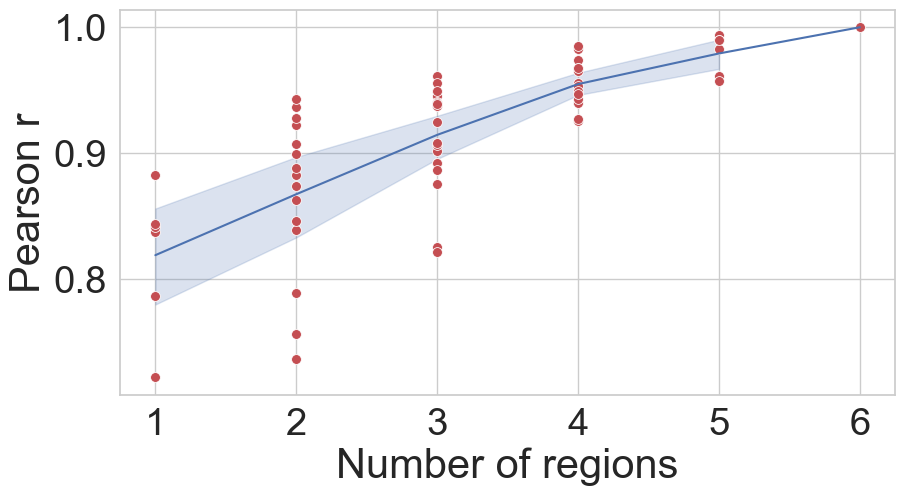

In [18]:
import seaborn as sns
sns.set_style("whitegrid")
# Adjust aspect ratio
plt.figure(figsize=(10, 5))

sns.lineplot(x='num_regions',y='pearson_corr',data=df_comb,color='b')


sns.scatterplot(x='num_regions',y='pearson_corr',data=df_comb,color='r',s=50)
plt.xlabel('Number of regions')
plt.ylabel('Pearson r')
sns.set(font_scale=2.5)
# plt.savefig("Pearson_corr.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)


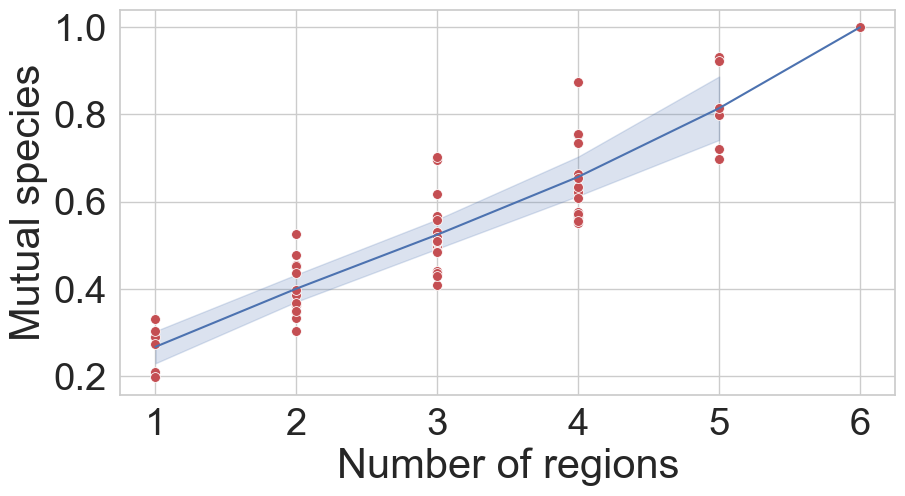

In [19]:
sns.set_style("whitegrid")
# Adjust aspect ratio
plt.figure(figsize=(10, 5))

sns.lineplot(x='num_regions',y='mutual_taxonomy',data=df_comb,color='b')
sns.scatterplot(x='num_regions',y='mutual_taxonomy',data=df_comb,color='r',s=50)
plt.xlabel('Number of regions')
plt.ylabel('Mutual species')
sns.set(font_scale=2.5)
# plt.savefig("mutual_taxonomy.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)


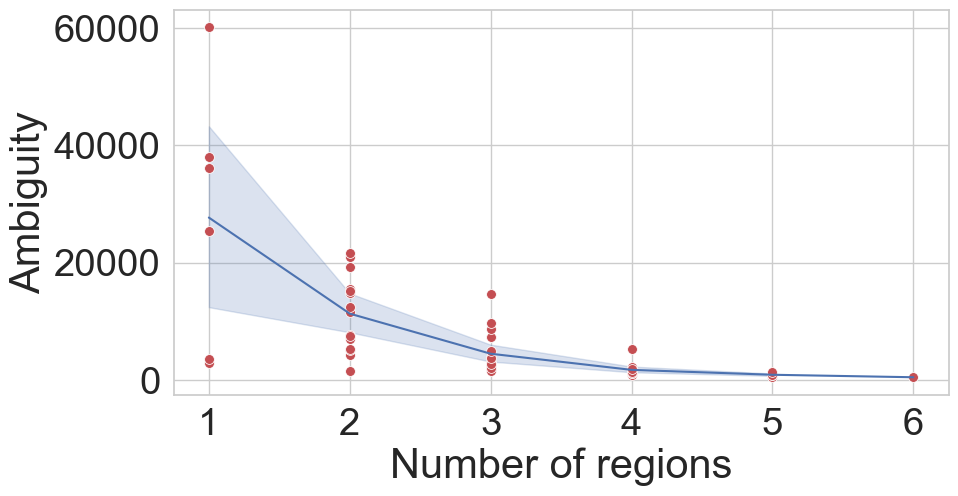

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

sns.lineplot(x='num_regions', y='Ambiguity', data=df_comb, color='b')
sns.scatterplot(x='num_regions', y='Ambiguity', data=df_comb, color='r', s=50)

plt.xlabel('Number of regions')
plt.ylabel('Ambiguity')

# # Use FuncFormatter to format y axis labels to 'k' format
# def thousands_format(x, pos):
#     'The two args are the value and tick position'
#     return '%1.0fk' % (x * 1e-3)

# formatter = ticker.FuncFormatter(thousands_format)

# plt.gca().yaxis.set_major_formatter(formatter)
sns.set(font_scale=2.5)

# plt.savefig("Ambiguity.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


C:\Users\Maor\AppData\Local\Temp\ipykernel_17716\2976400957.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_comb = results_df_s.groupby(by='region_combination').mean()


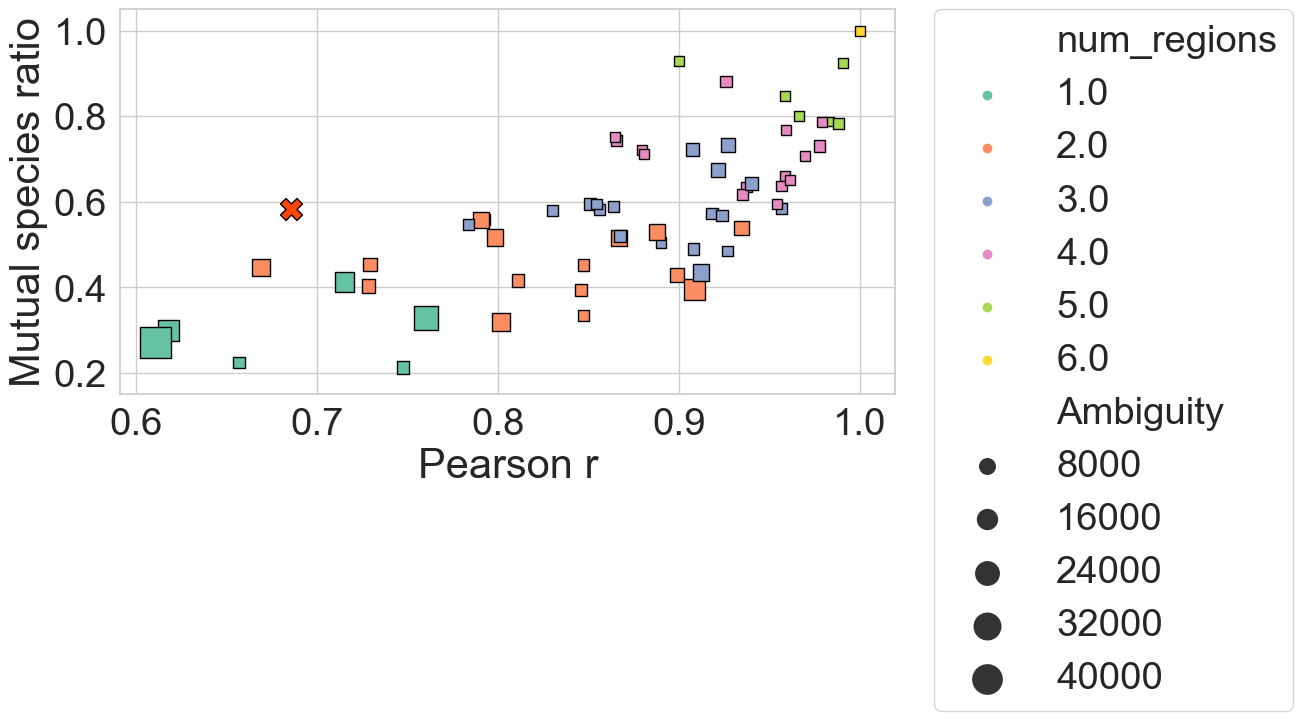

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Adjust aspect ratio
plt.figure(figsize=(10, 5))

results_df_s = results_df[results_df['tissue'] == 'R']

df_comb = results_df_s.groupby(by='region_combination').mean()

# Convert 'num_regions' column to categorical
df_comb['num_regions'] = df_comb['num_regions'].astype('category')

# Separate the data into two groups
df_comb_x = df_comb[df_comb.index == '1_2_4']
df_comb_others = df_comb[df_comb.index != '1_2_4']

# Create the scatter plot for all other combinations
scatter_others = sns.scatterplot(x='pearson_corr', y='mutual_taxonomy', data=df_comb_others, sizes=(50, 500), hue='num_regions', size='Ambiguity', palette='Set2', edgecolor='black', linewidth=1,marker='s')
# Create the scatter plot for the "1_2_4" combination
scatter_x = sns.scatterplot(x='pearson_corr', y='mutual_taxonomy', data=df_comb_x, color ='#FF4500', marker='X', s=250, edgecolor='black', linewidth=1)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0.15,1.05)
plt.xlabel('Pearson r')
plt.ylabel('Mutual species ratio')

sns.set(font_scale=2)
plt.savefig("Root_comb.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)


In [35]:
import plotly.express as px

# Specify the color sequence for discrete colors
color_discrete_sequence = px.colors.qualitative.Set2

# Create an interactive scatter plot
fig = px.scatter(df_comb, x='pearson_corr', y='mutual_taxonomy', 
                 color='num_regions', size = 'log10_Ambiguity', 
                 hover_data=[df_comb.index], 
                 color_discrete_sequence=color_discrete_sequence)

# Increase marker size
fig.update_traces(marker=dict(size=15, line=dict(width=2, color='DarkSlateGrey')))

# Show the plot
fig.show()
